In [1]:
%load_ext autoreload
%autoreload 2

# Getting started with granite-geospatial-biomass

This notebook demonstrates the usage of the granite-geospatial-biomass model hosted on [huggingface](https://huggingface.co/ibm-granite/granite-geospatial-biomass) for the prediction of above-ground biomass (AGB).

The granite-geospatial-biomass model is a fine-tuned geospatial foundation model that predicts AGB from [Harmonized Landsat and Sentinel-2 (HLS)](https://hls.gsfc.nasa.gov/) L30 optical satellite imagery. It was fine-tuned using training labels from [Global Ecosystem Dynamics Investigation (GEDI)](https://www.earthdata.nasa.gov/sensors/gedi) L4A lidar observations that has been sampled from [15 biomes](https://geospatial.tnc.org/datasets/b1636d640ede4d6ca8f5e369f2dc368b/about) across the globe. Biomes can span more than one continent and share similar vegetation type and physical and biogeographical dimensions driven by similar climate variables.

Please see the model card (*LINK*)for more information on model development, including the base foundation model.

This notebook guides the use of the granite-geospatial-biomass model for three experiments:

1. **Zero-shot for all biomes**: The granite-geospatial-biomass model is loaded and AGB predictions are evaluated on the test data which was not seen during fine-tuning.
2. **Zero-shot for a single biome**: The granite-geospatial-biomass model is loaded and AGB predictions are evaluated on the test data for the Taiga/boreal forest biome which was not seen during fine-tuning.
3. **Few-shot for a single biome**: The granite-geospatial-biomass model is further fine-tuned on training data from the Taiga/boreal forest biome and AGB predictions are subsequently evaluated on the associated test data which was not seen during fine-tuning.

The granite-geospatial-biomass model weights are available from the Hugging Face IBM Granite Model Repository (*LINK*). The required HLS and GEDI data to complete the experiments in this notebook is available through [Zenodo](https://doi.org/10.5281/zenodo.12356481).


## Setting up your environment

The granite-geospatial-biomass model is trained using the Terratorch framework ([link](https://github.com/IBM/terratorch/tree/main)). Terratorch simplifies the integration of foundation model backbones into the TorchGeo framework and provides generic LightningDataModules that can be built at runtime. For more information on Terratorch, please refer to the instructions in the [Terratorch Quick Start Guide](https://ibm.github.io/terratorch/quick_start/).

### If running locally
Before running the notebook, make sure you have created a python environment and installed the directory `granite-geospatial-biomass` using:

```sh
cd granite-geospatial-biomass
pip install -e .
```

This will install pytorch and Terratorch for you, amongst a few other libraries.

### If running on Colab

In [ ]:
# Clone the ibm-granite/granite-geospatial-biomass GitHub
!git clone https://github.com/ibm-granite/granite-geospatial-biomass.git

# Change directory. Move inside the tsfm repo.
%cd granite-geospatial-biomass

# Install the package
!pip install -e .

# Change directory. Standardize so below paths work with local notebook and colab.
%cd notebooks

## Running the code

In [2]:
# Standard
import os
import shutil
import glob
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np

# Third Party
import rioxarray as rio
from lightning.pytorch import Trainer
from terratorch.cli_tools import LightningInferenceModel
from huggingface_hub import hf_hub_download

# First Party
from utils.binwise_rmse import calc_binwise_rmse
from utils.dataset_scalers import calc_mean_std
from utils.plotting import plot_rgb_agb_gedi

Make sure our working directory is in `granite-geospatial-biomass/notebooks`

If not, run `%cd granite-geospatial-biomass/notebooks`

In [ ]:
%pwd

## Data and model preparation

Let's start with downloading the datasets from Zenodo:

In [4]:
# Download dataset from Zenodo
dataset_path = '../granite-geospatial-biomass-datasets.tar.gz'
!wget "https://zenodo.org/records/12356481/files/granite-geospatial-biomass-datasets.tar.gz?download=1" -O {dataset_path}

--2024-09-18 13:14:02--  https://zenodo.org/records/12356481/files/granite-geospatial-biomass-datasets.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8151007565 (7.6G) [application/octet-stream]
Saving to: '../granite-geospatial-biomass-datasets.tar.gz'

../granite-geospati 100%[===================>]   7.59G  28.1MB/s    in 5m 46s  

2024-09-18 13:19:49 (22.5 MB/s) - '../granite-geospatial-biomass-datasets.tar.gz' saved [8151007565/8151007565]



In [5]:
# Unpack compressed dataset
target_directory = '../'
!tar -xf {dataset_path} --directory {target_directory}

Download the model checkpoint from HuggingFace:

In [6]:
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-biomass", filename="biomass_model.ckpt")

## Zero-shot for all biomes
For the first experiment, we use the granite-geospatial-biomass model for inference on test data which was not seen during finetuning. Predictions of AGB are made using the HLS L30 data and evaluated against available GEDI L4A observations.

In [7]:
### Provide all necessary fils, paths, and hyperparameter

# Path to configuration file which contains all hyperparameters
config_path = '../configs/config.yaml'

# Path to directory with geotiff test images
predict_input_dir = '../granite-geospatial-biomass-datasets/all_ecos_datasplit/test_images/'

# List to define the bands in the input images. As currently configured, the model looks for following
# HLS bands: BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2
# The line below names all the bands in the input, so the ones above can be extracted. we use -1 for placeholders, as we dont care about those
UNUSED_BAND = "-1"
predict_dataset_bands = [UNUSED_BAND,"BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2",UNUSED_BAND,UNUSED_BAND,UNUSED_BAND,UNUSED_BAND]

# Path to directory with GEDI test labels - these will be used for plotting and evaluation further below
test_label_dir = '../granite-geospatial-biomass-datasets/all_ecos_datasplit/test_labels/'

In [8]:
# create subset of images for inference
images_for_inference = ['T10SFF_144_tile_img.tif', 'T33TUM_34_tile_img.tif', 'T47PRR_79_tile_img.tif']

labels_for_inference = ['T10SFF_144_tile_label.tif', 'T33TUM_34_tile_label.tif', 'T47PRR_79_tile_label.tif']

if not os.path.isdir("inference_images"):
    os.mkdir("inference_images")
    for inference_image in images_for_inference:
        shutil.copy(os.path.join(predict_input_dir, inference_image), os.path.join("inference_images", inference_image))

if not os.path.isdir("inference_labels"):
    os.mkdir("inference_labels")
    for inference_label in labels_for_inference:
        shutil.copy(os.path.join(test_label_dir, inference_label), os.path.join("inference_labels", inference_label))

In [9]:
# load the model with terratorch
model = LightningInferenceModel.from_config(config_path, ckpt_path, predict_dataset_bands)

/dccstor/geofm-finetuning/carlosgomes/terratorch/lib/python3.10/site-packages/lightning/pytorch/cli.py:518: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/u/carlosgomes/.local/share/jupyter/runtime/kernel-c53c3781-1d0d-4606-b34b-bd9b256c46f4.json'], args=['--config', '../configs/config.yaml', '--data.init_args.predict_dataset_bands', '[-1,BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,-1,-1,-1,-1]'].
Seed set to 42
No pretrained configuration specified for prithvi_swin_B model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
/dccstor/geofm-finetuning/carlosgomes/terratorch/lib/python3.10/site-packages/lightning/pytorch/cli.py:652: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
GPU available: True (cuda), used: Tr

In [10]:
inference_results, input_file_names = model.inference_on_dir("inference_images")

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

### Plotting inference results
We now plot a sample of AGB predictions for three different biomes:
- Temperate Conifer Forests
- Mediterranean Forests, Woodlands & Scrub
- Tropical & Subtropical Dry Broadleaf Forests

To highlight the sparsity of the GEDI observations, we overlay the AGB predictions with the coinciding GEDI observations.

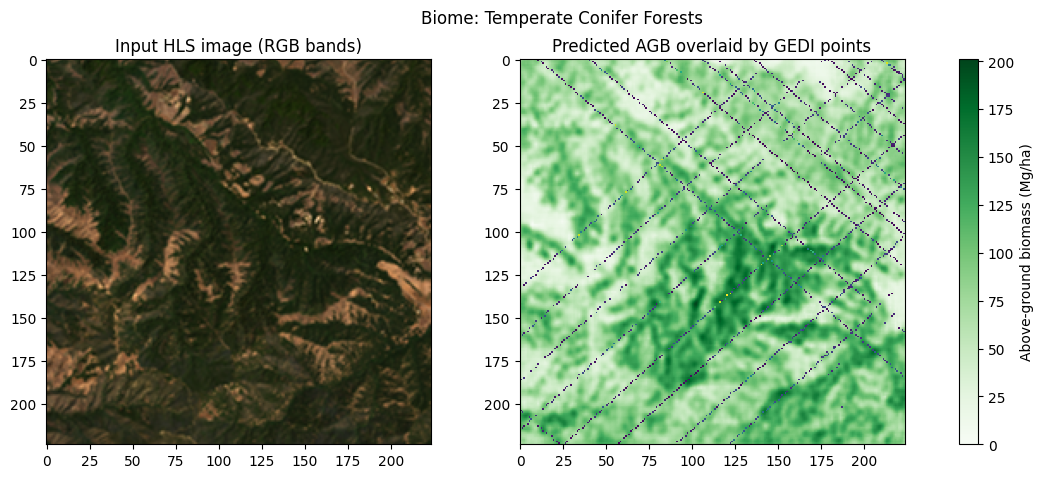

In [11]:
### Plot example image for Temperate Conifer Forests
biome = 'Temperate Conifer Forests'
tile_id = 'T10SFF_144' # Located in CA, USA

plot_rgb_agb_gedi(tile_id, "inference_images", input_file_names, inference_results, "inference_labels", biome)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


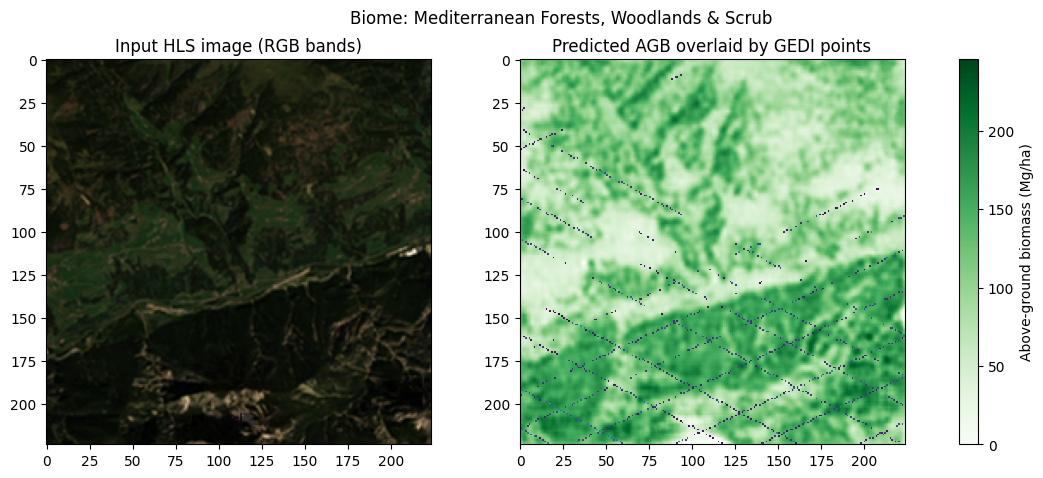

In [12]:
### Plot example image for Mediterranean Forests, Woodlands & Scrub
biome = 'Mediterranean Forests, Woodlands & Scrub'
tile_id = 'T33TUM_34_' # Located bordering Italy, Austria and Slovenia

plot_rgb_agb_gedi(tile_id, "inference_images", input_file_names, inference_results, "inference_labels", biome)

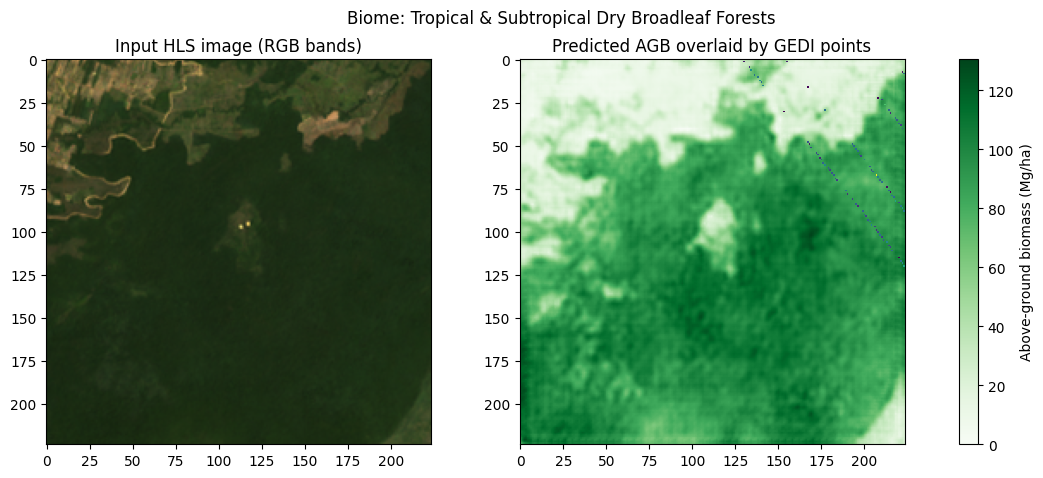

In [13]:
### Plot example image for Tropical & Subtropical Dry Broadleaf Forests
biome = 'Tropical & Subtropical Dry Broadleaf Forests'
tile_id = 'T47PRR_79_' # Located in Thailand

plot_rgb_agb_gedi(tile_id, "inference_images", input_file_names, inference_results, "inference_labels", biome)

### Model evaluation on bin-wise AGB ranges
Model performance is commonly evaluated within bins of AGB ranges because AGB values commonly skew towards lower values. Here we evaluate model performance with RMSE across four bins:
- 0-100 Mg/ha
- 100-200 Mg/ha
- 200-300 Mg/ha
- 0-300 Mg/ha


## Warning:
Below this cell, large RAM is required to keep the inference results in memory. A colab instance with more memory may be required. Alternatively, consider using a subset of the inputs.

In [14]:
# utility function to align inputs and outputs
def align_order_input_label_inference(input_file_paths, inference_results, label_file_paths):
    input_inference = zip(input_file_paths, inference_results)
    sorted_input_inference = sorted(input_inference, key=lambda x:x[0])
    sorted_input_file_paths, sorted_inference_results = zip(*sorted_input_inference)
    sorted_label_file_paths = sorted(label_file_paths)

    return sorted_input_file_paths, sorted_inference_results, sorted_label_file_paths

In [15]:
# carry out inference for all images now
inference_results, input_file_names = model.inference_on_dir(predict_input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

In [16]:
### Defining the evaluation bins of AGB values
bins = [
    [0, 100],
    [100, 200],
    [200, 300],
    [0, 300],
]

In [17]:
### Calling function with above arguments to calculate bin-wise RMSEs
# Name of experiment
experiment_name = 'all_ecos'
# Path to CSV file where evaluation metrics are stored
evaluation_file_path = '../experiments/binwise_rmse.csv'

test_labels = list(glob.glob(os.path.join(test_label_dir, '*.tif')))
sorted_input_file_paths, sorted_inference_results, sorted_label_file_paths = align_order_input_label_inference(input_file_names, inference_results, test_labels)
calc_binwise_rmse(bins, experiment_name, sorted_inference_results, sorted_label_file_paths, evaluation_file_path)

In [18]:
### Read the calculated metrics
metrics_df = pd.read_csv(evaluation_file_path)
metrics_df

,experiment_name,0-100,100-200,200-300,0-300
0,all_ecos,35.289284,67.201091,131.23398,50.808229


## Zero-shot for a single biome (Taiga)

The data used in these experiments has been separated into biomes according to biome boundaries. In the following, we use the Taiga biome as an example to build a biome-specific biomass model. Taiga, also known as boreal forest or snow forest, biome is characterized by coniferous forests consisting mostly of pines, spruces, and larches. It is the largest land biome in the world.

In this zero-shot for a single biome experiment, we repeat the above inference but evaluate the model performance for the Taiga biome only. In the next experiment, we show how the model can be efficiently be fine-tuned to improve prediction skill on this specific region.

In [19]:
### Provide all necessary fils, paths, and hyperparameter

# Path to configuration file which contains all hyperparameters
config_path = '../configs/config.yaml'

# Path to directory with geotiff test images
predict_input_dir = '../granite-geospatial-biomass-datasets/taiga_datasplit/test_images'

taiga_test_label_dir = '../granite-geospatial-biomass-datasets/taiga_datasplit/test_labels/'

# List to define the bands in the input images. As currently configured, the model looks for following
# HLS bands: BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2
# The line below names all the bands in the input, so the ones above can be extracted. we use -1 for placeholders, as we dont care about those
UNUSED_BAND = "-1"
predict_dataset_bands = [UNUSED_BAND,"BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2",UNUSED_BAND,UNUSED_BAND,UNUSED_BAND,UNUSED_BAND]

In [20]:
# load the model with terratorch
model = LightningInferenceModel.from_config(config_path, ckpt_path, predict_dataset_bands)

/dccstor/geofm-finetuning/carlosgomes/terratorch/lib/python3.10/site-packages/lightning/pytorch/cli.py:518: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/u/carlosgomes/.local/share/jupyter/runtime/kernel-c53c3781-1d0d-4606-b34b-bd9b256c46f4.json'], args=['--config', '../configs/config.yaml', '--data.init_args.predict_dataset_bands', '[-1,BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,-1,-1,-1,-1]'].
Seed set to 42
No pretrained configuration specified for prithvi_swin_B model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
/dccstor/geofm-finetuning/carlosgomes/terratorch/lib/python3.10/site-packages/lightning/pytorch/cli.py:652: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
GPU available: True (cuda), used: Tr

In [21]:
inference_results, input_file_names = model.inference_on_dir(predict_input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

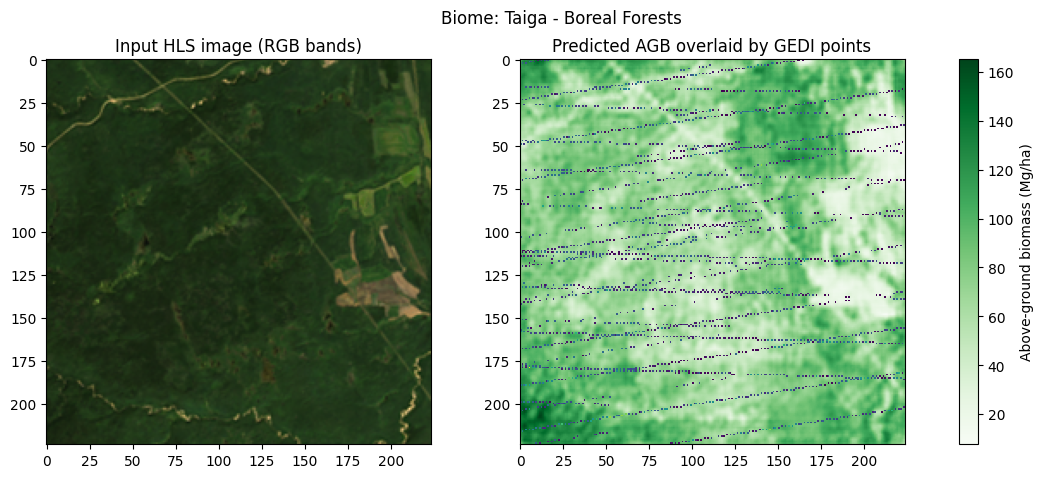

In [22]:
### Plot example image for Taiga
biome = 'Taiga - Boreal Forests'
tile_id = 'T13UGT_175' # Located in Canada

plot_rgb_agb_gedi(tile_id, predict_input_dir, input_file_names, inference_results, taiga_test_label_dir, biome)

### Model evaluation on bin-wise AGB ranges

In [23]:
### Calling function with above arguments to calculate bin-wise RMSEs

test_labels = list(glob.glob(os.path.join(taiga_test_label_dir, '*.tif')))
sorted_input_file_paths, sorted_inference_results, sorted_label_file_paths = align_order_input_label_inference(input_file_names, inference_results, test_labels)
# Name of experiment
experiment_name = 'all_ecos_Taiga'
# Path to CSV file where evaluation metrics are stored
evaluation_file_path = '../experiments/binwise_rmse.csv'

calc_binwise_rmse(bins, experiment_name, sorted_inference_results, sorted_label_file_paths, evaluation_file_path)

In [24]:
### Read the calculated metrics
metrics_df = pd.read_csv(evaluation_file_path)
metrics_df

,experiment_name,0-100,100-200,200-300,0-300
0,all_ecos,35.289284,67.201091,131.233980,50.808229
1,all_ecos_Taiga,16.637188,79.099615,168.389755,30.755789


The above evaluation shows the skill of the granite-geospatial-biomass model across all 15 biomes (all_ecos) and across the Taiga biome only (all_ecos_Taiga)

## Few-shot for a single biome (Taiga)

The granite-geospatial-biomass model has been fine-tuned from a geospatial foundation model using data sampled from 15 diverse biomes. To provide a more precise prediction, we hereby show that further fine-tuning with data from a specific biome, namely Taiga, can improve model skill for that biome.

As per common practice, we split the HLS and GEDI data that coincides with the Taiga biome into training, validation and test patches. We then calculate mean and standard deviation values of the training dataset and create a new `config-finetune.yaml` file to submit the training run. This training data is part of the same zenodo repository listed above.

In [25]:
### Provide all necessary fils, paths

# Path to dictonary which holds your training, validation and test_patches
finetune_data_path = '../granite-geospatial-biomass-datasets/taiga_datasplit/'

# Path to configuration file to be created for fine-tuning
finetune_config_path = '../configs/config-finetune.yaml'

# lets download the full lightning checkpoint to finetune on
full_lightning_ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-biomass", filename="biomass_model_lightning.ckpt")

biomass_model_lightning.ckpt:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

In [26]:
# Completing the data roots for all data splits
train_data_root = os.path.join(finetune_data_path, 'train_images')
train_label_data_root = os.path.join(finetune_data_path, 'train_labels')
val_data_root = os.path.join(finetune_data_path, 'val_images')
val_label_data_root = os.path.join(finetune_data_path, 'val_labels')
test_data_root = os.path.join(finetune_data_path, 'test_images')
test_label_data_root = os.path.join(finetune_data_path, 'test_labels')

In [27]:
# Calling function to calculate the scalers of the training dataset
train_mean_std = calc_mean_std(train_data_root)

In [28]:
# Dumping new training data paths and scalers into new config file, using previous config file as template
with open('../configs/config.yaml', "rb") as f:
    config_dict = yaml.safe_load(f)
config_dict['data']['init_args']['means'] = train_mean_std['mean'].values[1:7].tolist() #Selecting appropriate bands
config_dict['data']['init_args']['stds'] = train_mean_std['std'].values[1:7].tolist() #Selecting appropriate bands
config_dict['data']['init_args']['train_data_root'] = train_data_root
config_dict['data']['init_args']['train_label_data_root'] = train_label_data_root
config_dict['data']['init_args']['val_data_root'] = val_data_root
config_dict['data']['init_args']['val_label_data_root'] = val_label_data_root
config_dict['data']['init_args']['test_data_root'] = test_data_root
config_dict['data']['init_args']['test_label_data_root'] = test_label_data_root
with open(finetune_config_path, 'w') as f:
    yaml.dump(config_dict, f)

In [29]:
### Run the following command for fine-tuning in your terminal with activated terratorch environment

print(f'terratorch fit --config {finetune_config_path} --ckpt_path {full_lightning_ckpt_path}')

terratorch fit --config ../configs/config-finetune.yaml --ckpt_path /u/carlosgomes/.cache/huggingface/hub/models--ibm-granite--granite-geospatial-biomass/snapshots/32a02e8d48c6e96680688b77d720598b54da26f3/biomass_model_lightning.ckpt


### Monitor training
The training process can be monitored with Lightning's loggers, e.g. `TensorBoardLogger` or `CSVLogger`.

Below we show the validation RMSE from the original granite-geospatial-biomass model when fine-tuned on all biomes (blue), and the validation RMSE when it is further fine-tuned on data only from the Taiga biome (orange).

You may replace these with the paths to the logs generated by your own training in the cell below.

In [30]:
### Training logs for validation RMSE
training_all_ecos = pd.read_csv('../experiments/all_ecos_random_version_4.csv')
finetune_single_eco = pd.read_csv('../experiments/finetune_region_version_2.csv')

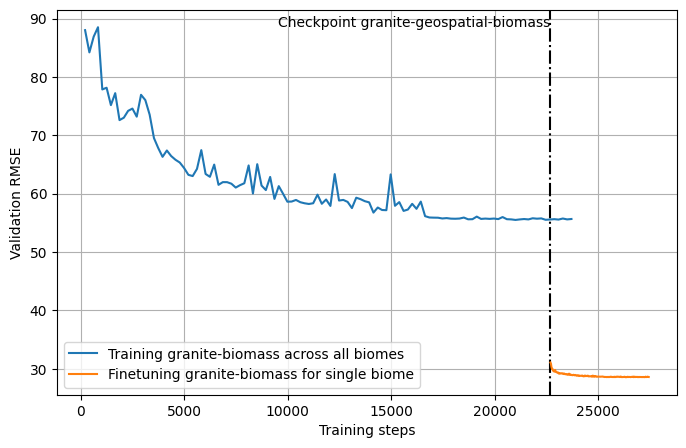

In [31]:
### Plot training curves
fig = plt.figure(figsize=(8,5))
plt.grid()
plt.axvline(x=finetune_single_eco.Step[0], color='k', linestyle='-.');
plt.text(x=finetune_single_eco.Step[0], y=training_all_ecos.Value.max(),
         s='Checkpoint granite-geospatial-biomass', color='k', horizontalalignment='right');
plt.plot(training_all_ecos['Step'], training_all_ecos['Value'], label='Training granite-biomass across all biomes')
plt.plot(finetune_single_eco['Step'], finetune_single_eco['Value'], label='Finetuning granite-biomass for single biome')
plt.legend()
plt.xlabel('Training steps')
plt.ylabel('Validation RMSE');

### Inference with the model fine-tuned on the Taiga biome

In [ ]:
### Provide all necessary files, paths

# Patch to your Taiga fine-tuned model checkpoint
# under notebooks/experiments/version_?/checkpoints/epoch=?_state_dict.ckpt
finetune_ckpt_path = '<your_path_here>'

# Path to directory with test images of Taiga region
finetune_predict_input_dir = predict_input_dir

# List to define the bands in the input images. As currently configured, the model looks for following
# HLS bands: BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2
# The line below names all the bands in the input, so the ones above can be extracted. we use -1 for placeholders, as we dont care about those
UNUSED_BAND = "-1"
predict_dataset_bands = [UNUSED_BAND,"BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2",UNUSED_BAND,UNUSED_BAND,UNUSED_BAND,UNUSED_BAND]

In [ ]:
# load the model with terratorch
model = LightningInferenceModel.from_config(finetune_config_path, finetune_ckpt_path, predict_dataset_bands)

In [ ]:
inference_results, input_file_names = model.inference_on_dir(finetune_predict_input_dir)

In [ ]:
### Plot example image for Taiga
biome = 'Taiga - Boreal Forests'
tile_id = 'T13UGT_175' # Located in Canada

plot_rgb_agb_gedi(tile_id, finetune_predict_input_dir, input_file_names,inference_results, taiga_test_label_dir, biome)

### Evaluation of the model fine-tuned on the Taiga biome

In [ ]:
### Calling function with above arguments to calculate bin-wise RMSEs

test_labels = list(glob.glob(os.path.join(taiga_test_label_dir, '*.tif')))
sorted_input_file_paths, sorted_inference_results, sorted_label_file_paths = align_order_input_label_inference(input_file_names, inference_results, test_labels)
# Name of experiment
experiment_name = 'finetuned_Taiga'
# Path to CSV file where evaluation metrics are stored
evaluation_file_path = '../experiments/binwise_rmse.csv'

calc_binwise_rmse(bins, experiment_name, sorted_inference_results, sorted_label_file_paths, evaluation_file_path)

In [ ]:
### Read the calculated metrics
metrics_df = pd.read_csv(evaluation_file_path)
metrics_df

The above evaluation shows further fine-tuning the model on a specific biome improves model performance across almost all bin ranges. Of note are the signifcant improvements between 100-300 Mg/ha which are typically the most challenging ranges to predict.

We hope this notebook provides you with the tools and understanding to drive innovation forward.